In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import nbformat
import datetime as dt
import scipy.stats as stats
import plotly.graph_objects as go

In [2]:
# securities = vbt.YFData.download(symbols=['SPY', 'XLK', 'XLV', 'XLF', 'XLP', 'XLI', 'XLE', 'XLU', 'XLRE', 'XLY', 'XLB'])
securities = vbt.YFData.download(symbols=['MTN'])

In [3]:
sectors = securities.data.keys()
df = pd.DataFrame(securities.data['MTN']['Close'])

In [4]:
df.columns = ['MTN']

In [5]:
# drop null
df = df.dropna()

In [6]:
# import weather_hist into a dataframe
weather_hist = pd.read_csv('data/weather_hist.csv', index_col=0) 
weather_hist.index = pd.to_datetime(weather_hist.index)

In [7]:
df.index = pd.to_datetime(df.index, utc = True)
# remove time zone from df index
df.index = pd.Series(df.index).dt.tz_localize(None)
# join weather_hist with df on date
df = df.join(weather_hist, how='inner',on='Date', lsuffix='_df', rsuffix='_weather_hist')

In [8]:
df.columns

Index(['MTN', 'apparent_temperature (°F)', 'precipitation (mm)',
       'cloudcover (%)'],
      dtype='object')

In [9]:
df.index = df.index.date
df['Date'] = pd.to_datetime(df.index)

In [10]:
snow_hist = pd.read_csv('data/vail_snowpack.csv', index_col=0)
snow_hist['Year'] = snow_hist.index
snow_hist = pd.melt(snow_hist, id_vars=['Year', 'Day'], value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
             var_name='Month', value_name='Snowpack')
# Melt dataframe to transform month columns into "month" and "snowpack" columns

# Combine "year", "day", and "month" columns into one date index column
snow_hist['Date'] = pd.to_datetime(snow_hist['Year'].astype(str) + '-' +
                                   snow_hist['Month'].str.slice(0, 3) + '-' + 
                                   snow_hist['Day'].astype(str), 
                                   errors='coerce')
snow_hist = snow_hist.set_index('Date')

# Drop unnecessary columns and sort by date
snow_hist = snow_hist.drop(['Year', 'Day', 'Month'], axis=1).sort_index()
# drop all rows with dates less than 2010
snow_hist = snow_hist[snow_hist.index >= '2010-01-01']
snow_hist.head()
snow_hist.index = pd.to_datetime(snow_hist.index)

In [11]:
# get min of snowpack for all years
snow_hist.Snowpack.min()

0.0

In [12]:
# join snow_hist with df on date
df = df.join(snow_hist, how='inner',on='Date', lsuffix='_df', rsuffix='_snow_hist')

In [13]:
df.head()

,MTN,apparent_temperature (°F),precipitation (mm),cloudcover (%),Date,Snowpack
2010-01-04,28.942707,10.5,0.0,27,2010-01-04,7.2
2010-01-05,28.998268,12.9,0.0,3,2010-01-05,7.2
2010-01-06,28.117367,15.6,0.0,36,2010-01-06,7.3
2010-01-07,28.561792,18.6,0.0,4,2010-01-07,7.4
2010-01-08,29.672821,22.8,0.0,100,2010-01-08,7.4


In [14]:
# rename apparent_temperature to temp
df.rename(columns={
  'apparent_temperature (°F)':'temp',
  'precipitation (mm)':'precip',
  'cloudcover (%)':'clouds',
  'Date':'date',
  'Snowpack':'snowpack'
  }, inplace=True)

In [15]:
df.snowpack.min()

0.0

In [16]:
def weather_score(row):
    #! What if it is 72 -> big nm 
    # temp = min(abs(row['temp'] - 72.0001) ** -1, 50)
    temp = stats.norm.pdf(row['temp'], 72, 12.5) * 1500
    precip = -15 * row['precip'] ** 0.25
    return 0.5 * (100 - row['clouds']) + temp + precip
# how to optimize weather score? optimize for what nd when?
# generate column from lambda function over rows
df['niceness'] = df.apply(lambda row: weather_score(row), axis=1)
# df['niceness'] = df.apply(lambda row: weather_score(row['temp'], row['clouds'], row['precip']), axis=1)

In [17]:
# generate new column from lambda function over rows based on previous row
df['delta_nice'] = df.niceness.diff()

In [18]:
# plot date and snowpack as a time series
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.snowpack, name='snowpack'))
fig.update_layout(title='Snowpack', xaxis_title='Date', yaxis_title='Snowpack (inches)')
fig.show()

In [19]:
# get correlation btw delta nice and snowpack
df['delta_nice'].corr(df['snowpack'])

0.010013638183379615

In [20]:
# get min of snowpack
df['snowpack'].min()

0.0

In [21]:
# plot snowpack versus MTN as scatterplot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.snowpack, y=df.MTN, mode='markers', name='MTN'))
fig.update_layout(title='MTN vs Snowpack', xaxis_title='Snowpack (inches)', yaxis_title='MTN')

In [24]:
top_interval = -1
top_corr = 0
top_delta = -1
# create heatmap of correlation between delta_nice and profit
# create numpy array of zeros
heatmap = np.zeros((55, 55))
for i in range(5, 275, 5):
  for d in range(5, 275, 5):
    df['profit'] = df['MTN'].diff(i)
    df['delta_snowpack'] = df.snowpack.diff(d)
    # calculate correlation between delta_nice and profit
    corr = df.delta_snowpack.corr(df.profit)
    heatmap[i // 5 - 1][d // 5 - 1] = corr
    if abs(corr) > abs(top_corr):
      top_corr = corr
      top_interval = i
      top_delta = d
(top_interval, top_delta, top_corr)
# plot heatmap
fig = go.Figure(data=go.Heatmap(
                    z=heatmap,
                    x=np.arange(5, 275, 5), # profit offset
                    y=np.arange(5, 275, 5), # delta_nice offset
                    colorscale='Viridis')
                    )
fig.update_layout(title='Correlation between snowpack and profit', xaxis_title='Profit offset', yaxis_title='Snowpack offset')
fig.show()

In [26]:
(top_interval, top_delta, top_corr)

(105, 95, -0.26734614588691546)

In [27]:
df['delta_snowpack'] = df.snowpack.diff(145)
df['delta_nice'] = df.niceness.diff(125)
# get corr
df['delta_snowpack'].corr(df['delta_nice'])

-0.3146868817953311

In [28]:
# snowpack versus mtn cor
df['snowpack'].min()

0.0

In [29]:
(top_interval, top_delta, top_corr)
df['profit'] = df['MTN'].diff(top_interval)
df['delta_snowpack'] = df.snowpack.diff(top_delta)

This is really weird, the interval matches exactly and i would think it's the same data, but it's not--if we check the correlation, it's like 0.44 - what?

In [30]:
df['profit'] = df['MTN'].diff(100)
df['delta_nice'] = df.delta_snowpack.diff(140)

<AxesSubplot: xlabel='delta_snowpack', ylabel='profit'>

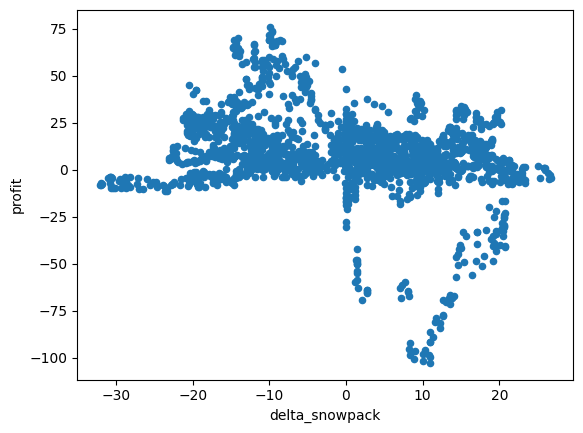

In [31]:
# create matplotlib scatterplot of delta_nice and profit
df.plot.scatter(x='delta_snowpack', y='profit')

In [32]:
# get profit mean
print(df.profit.mean())
# get profit mean for delta_nice sections
sections = df.groupby(pd.cut(df.delta_snowpack, 10))
# for each section, get the percent of each section that is positive
for name, section in sections:
  print(name, section.profit[section.profit > 0].count() / section.profit.count())
# get percent of profit < 20 or greater than 30
print(df.profit[(df.profit < -5) | (df.profit > 30)].count() / df.profit.count())

7.928595080280935
(-32.159, -26.22] 0.0
(-26.22, -20.34] 0.6708860759493671
(-20.34, -14.46] 0.7463768115942029
(-14.46, -8.58] 0.9226666666666666
(-8.58, -2.7] 0.8307692307692308
(-2.7, 3.18] 0.8306636155606407
(3.18, 9.06] 0.7933491686460807
(9.06, 14.94] 0.7425149700598802
(14.94, 20.82] 0.6933333333333334
(20.82, 26.7] 0.32558139534883723
0.18501655629139072


In [ ]:
# strat -> use options and do straddle when delta nice is low and calls when delta nice is high

In [1]:
df['profit'] = df['MTN'].diff(100)
df['delta_nice'] = df.niceness.diff(140)
# create a regression on delta_nice and profit
slope, intercept, r_value, p_value, std_err = stats.linregress(df.delta_nice, df.profit)
# plot the regression line
import matplotlib.pyplot as plt
# plot scatterplot of data in plotly
fig = go.Figure()
from sklearn import linear_model
regr = linear_model.LinearRegression()
# drop nan
df = df.dropna()
# import px
import plotly.express as px
slope, intercept = np.polyfit(df['delta_nice'], df['profit'], 1)

# Create scatter plot of the data
fig = px.scatter(df, x="delta_nice", y="profit")

# Add regression line to the plot
fig.add_scatter(x=df['delta_nice'], y=df['delta_nice'] * slope + intercept, mode='lines', name='regression line')

# Show plot
fig.show()

NameError: name 'df' is not defined

In [48]:
# evaluate the regression
from sklearn.metrics import mean_squared_error, r2_score
# Make predictions using the testing set
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(df['delta_nice'].values.reshape(-1, 1), df['profit'])

y_pred = regr.predict(df['delta_nice'].values.reshape(-1, 1))
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(df['profit'], y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(df['profit'], y_pred))

Coefficients: 
 [0.15667366]
Mean squared error: 478.77
Coefficient of determination: 0.10


In [25]:
df[['delta_nice', 'profit']].corr()

,delta_nice,profit
delta_nice,1.00000,0.00116
profit,0.00116,1.00000


In [22]:
# create scatterplot of delta_nice vs profit
fig = go.Figure(data=go.Scatter(
    x=df['delta_nice'],
    y=df['profit'],

    mode='markers',
    marker=dict(
      
      size=16,
      color=df['niceness'], # set color equal to a third variable
      colorscale='Viridis', # one of plotly colorscales
      showscale=True
    )
))
fig.show()
# get correlation of delta_nice and profit
df[['delta_nice', 'profit']].corr()

,delta_nice,profit
delta_nice,1.000000,-0.004473
profit,-0.004473,1.000000


In [16]:
df.head()

,MTN,temp,precip,clouds,niceness,delta_nice
Date,,,,,,
2010-01-04 05:00:00,28.942711,10.5,0.0,27,36.500265,NaN
2010-01-05 05:00:00,28.998262,12.9,0.0,3,48.500670,12.000405
2010-01-06 05:00:00,28.117367,15.6,0.0,36,32.001817,-16.498853
2010-01-07 05:00:00,28.561783,18.6,0.0,4,48.005214,16.003397
2010-01-08 05:00:00,29.672838,22.8,0.0,100,0.020703,-47.984511


In [18]:
# add buy column with true if delta_nice > 0
df['sell'] = df.delta_nice > 31
df['buy'] = df.delta_nice < -1
# df = df[df.index.year == 2016]
# create portfolio and run backtest
portfolio = vbt.Portfolio.from_signals(df['MTN'], df.buy, df.sell, freq='D', )
portfolio.stats()

Start                               2010-01-04 05:00:00
End                                 2019-12-31 05:00:00
Period                               2516 days 00:00:00
Start Value                                       100.0
End Value                                    616.429034
Total Return [%]                             516.429034
Benchmark Return [%]                         687.902559
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               31.13076
Max Drawdown Duration                 211 days 00:00:00
Total Trades                                        380
Total Closed Trades                                 379
Total Open Trades                                     1
Open Trade PnL                               -10.435304
Win Rate [%]                                   51.71504
Best Trade [%]                                22.540645
Worst Trade [%]                              -12

In [37]:
portfolio.beta()

0.7879259060525181

In [38]:
portfolio.plot().show()

In [39]:
returns_df = portfolio.exit_trades.records_readable[['Entry Timestamp', 'Exit Timestamp', 'Return']]
# set returns_df index to Exit Timestamp
returns_df.set_index('Exit Timestamp', inplace=True)

In [40]:
# convert returns_df index to a datetime
returns_df.index = pd.to_datetime(returns_df.index)
merged_df = pd.merge_asof(returns_df, df, left_index=True, right_index=True)

In [55]:
# for each entry timestamp, get the delta_nice for that row
merged_df['entry_nice'] = merged_df.apply(lambda row: df.loc[row['Entry Timestamp']]['delta_nice'], axis=1)

In [56]:
# plot delta_nice and entry_nice as inputs and return as output
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_df['entry_nice'], y=merged_df['Return'], mode='markers', name='markers'))
fig.show()

In [59]:
# run linear regressin on delta_nice vs Return
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['entry_nice'], merged_df['Return'])
print('slope: ', slope)
print('intercept: ', intercept)
print('r-squared: ', r_value ** 2)
print('p_value: ', p_value)
print('std_err: ', std_err)

# plot linear regression
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_df['entry_nice'], y=merged_df['Return'], mode='markers', name='data'))
fig.add_trace(go.Scatter(x=merged_df['entry_nice'], y=intercept + slope*merged_df['entry_nice'], mode='lines', name='fitted line'))
# add axis labels
fig.update_layout(
    xaxis_title="Entry Nice",
    yaxis_title="Return",
    font=dict(
        # make it open sans light
        family="Open Sans Light, sans-serif",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

slope:  9.406446703284756e-05
intercept:  0.005770456912263319
r-squared:  0.009537706612375697
p_value:  0.090230256483515
std_err:  5.534290674475909e-05


In [61]:
# run linear regressin on delta_nice vs Return
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['delta_nice'], merged_df['Return'])
print('slope: ', slope)
print('intercept: ', intercept)
print('r_value: ', r_value)
print('p_value: ', p_value)
print('std_err: ', std_err)
print('r-squared:', r_value**2)

# plot linear regression
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_df['delta_nice'], y=merged_df['Return'], mode='markers', name='data'))
fig.add_trace(go.Scatter(x=merged_df['delta_nice'], y=intercept + slope*merged_df['delta_nice'], mode='lines', name='fitted line'))
# add axis labels
fig.update_layout(
    xaxis_title="delta_nice",
    yaxis_title="Return",
    font=dict(
        # make it open sans light
        family="Open Sans Light, sans-serif",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

slope:  -7.147382770050193e-05
intercept:  0.0068346259690526025
r_value:  -0.04584970461893682
p_value:  0.42725581779618504
std_err:  8.990687548296504e-05
r-squared: 0.0021021954136437562


In [58]:
# get statistic for how much the regression line explains the data

r-squared: 0.009537706612375697


In [20]:
returns_by_sector = {}
baseline_returns = {
    # for stocks period
    # 'SPY': 0.6036, 
    # for bonds period
    # 'SPY': 1.8926, 
    # 'XLK': 1.1167,
    # 'XLV': 0.5066, 
    # 'XLF': 0.6214,
    # 'XLP': 0.2703,
    # 'XLI': 0.5382,
    # 'XLE': -0.1008,
    # 'XLU': 0.4613,
    # 'XLRE': 0.2603,
    # 'XLY': 0.5988,
    # 'XLB': 0.3828,
    # 'BND': -0.0484,
    # for more bonds + options period
    'SPY': 0.999,
    'GOVT': -0.0167,
    'LQD': -0.032,
    'MUB': -0.018,
    'HYG': -0.077,
    'MBB': -0.033,
    '^BXR': 0.4812,
    'PBP': 0.082,
}
# ['SPY', 'GOVT', 'LQD', 'MUB', 'HYG', 'MBB', 'BXR', 'PBP']

for sector in sectors:
    df.buy = df.delta_nice > 0
    df.sell = df.delta_nice < -9.66
    portfolio = vbt.Portfolio.from_signals(df[sector], df.buy, df.sell, freq='D')
    # excess returns
    if sector == 'BXR':
        print(portfolio.total_return())
        print(baseline_returns[sector])
        print(portfolio.stats())
    returns_by_sector[sector] = portfolio.total_return() - baseline_returns[sector]
    # get total perent change of sector

In [21]:
# create a bar chart from returns_by_sector
fig = go.Figure(data=[
    go.Bar(x=list(returns_by_sector.keys()), 
    y=list(returns_by_sector.values()))
    ])
fig.show()

In [22]:
# df = df[df.index.year]
optimal_moves = {}
def get_optimal_moves(sector):
  num = 10
  entry_points = np.linspace(-40,-1, num=num)
  exit_points = np.linspace(0,40, num=num)
  returns_mtx = pd.DataFrame(columns=entry_points, index=exit_points)
  for entry in entry_points:
    for exit in exit_points:
      df['buy'] = df.delta_nice < entry
      df['sell'] = df.delta_nice > exit
      portfolio = vbt.Portfolio.from_signals(df[sector], df.buy, df.sell, freq='D')
      returns_mtx[entry][exit] = portfolio.total_return()
  # get row and column of max val in returns_matrix
  # print(returns_mtx)
  # cast the cells to floats
  returns_mtx = returns_mtx.astype(float)
  col = returns_mtx.max().idxmax()
  # find the row with the maximum value
  row = returns_mtx[col].idxmax()
  return (row, col)
  # returns_mtx.vbt.heatmap(
  #         xaxis_title = "entry",
  #         yaxis_title="exit").show()

for s in sectors:
  optimal_moves[s] = get_optimal_moves(s)

In [23]:
optimal_moves

{'SPY': (31.111111111111114, -1.0),
 'GOVT': (40.0, -18.333333333333336),
 'LQD': (40.0, -1.0),
 'MUB': (35.55555555555556, -1.0),
 'HYG': (40.0, -5.333333333333336),
 'MBB': (40.0, -1.0),
 '^BXR': (31.111111111111114, -1.0),
 'PBP': (31.111111111111114, -1.0)}

In [24]:
returns_by_sector = {}
baseline_returns = {
    # for stocks period
    # 'SPY': 0.6036, 
    # for bonds period
    # 'SPY': 1.8926, 
    # 'XLK': 1.1167,
    # 'XLV': 0.5066, 
    # 'XLF': 0.6214,
    # 'XLP': 0.2703,
    # 'XLI': 0.5382,
    # 'XLE': -0.1008,
    # 'XLU': 0.4613,
    # 'XLRE': 0.2603,
    # 'XLY': 0.5988,
    # 'XLB': 0.3828,
    # 'BND': -0.0484,
    # for more bonds + options period
    'SPY': 0.999,
    'GOVT': -0.0167,
    'LQD': -0.032,
    'MUB': -0.018,
    'HYG': -0.077,
    'MBB': -0.033,
    '^BXR': -0.4812,
    'PBP': -0.082,
}
sharpes = {}
# ['SPY', 'GOVT', 'LQD', 'MUB', 'HYG', 'MBB', 'BXR', 'PBP']

for sector in sectors:
    df['buy'] = df.delta_nice < optimal_moves[sector][0]
    df['sell'] = df.delta_nice > optimal_moves[sector][1]
    portfolio = vbt.Portfolio.from_signals(df[sector], df.buy, df.sell, freq='D')
    # excess returns
    returns_by_sector[sector] = portfolio.total_return() - baseline_returns[sector]
    sharpes[sector] = portfolio.stats()['Sharpe Ratio']
    # get total perent change of sector

print(sharpes)
fig = go.Figure(data=[
    go.Bar(
        # title="Excess Returns by Sector + Sharpes",
        # add title to graph
        x=list(returns_by_sector.keys()), 
        y=list(returns_by_sector.values()),
        # add a legend for marker
        marker=dict(color=list(sharpes.values()), showscale=True)
        ),
    ])

fig.update_layout(title="Excess Returns by Sector + Sharpes")

fig.show()


{'SPY': 1.4209496253672005, 'GOVT': 0.8937280004211188, 'LQD': 1.1339569124099922, 'MUB': 1.002027076774311, 'HYG': 1.131625111385349, 'MBB': 1.178956988618207, '^BXR': 1.000595413859099, 'PBP': 0.8896996917905553}


In [1]:
# create correlation matrix between sectors
df.corr()

NameError: name 'df' is not defined